On 2023/01/26, we discussed it would be more interesting to analyze **conditional probabilities** (as opposed to unconditional probabilities), since language is largely contextual). To this end, we agreed on:

- Run the analysis and comparisons in terms of tokens (as opposed to text).
- Running **bi-gram** analysis of the words that co-occur more often within the beginning of the documents.
- Use the first token of the bigram to condition the LM and observe the conditional probability of the second token, given the first one: $P(N_{w_2}(K) > 0|w_1)$

Comparing the text and the set of tokens in terms of indices, mitigates issues with tokenization that arise in models like GPT2 or GPT-Neo, where **"data"** or **" data"** are represented differently. Note however, that we do not consider the probability mass (in our estimates) assigned to the sequence of tokens **"d" "a" "t" "a"**. We set to revisit this issue later if we find a big gap between model and data distributions.


One pseudo-algorithm for computing the terms frequencies is:

```
Pseudocode: Compute the token frequencies of the first 100 tokens across all documents in the provided dataset.
input: Tokenizer (T), docs (D)
output: frequencies<int, int>

frequencies<int, int> = dict()

for d in D:
  tokenized_doc = T.tokenize(d)
  tokenized_doc = tokenized_doc.slice(100)  // get first 100 

  frequencies.update_counts(tokenized_doc)
end

return frequencies
```

~~Implementation-wise, if we obtain a list of all possible document names, we can parallelize the terms counts.~~ However, chances are we cannot use the "_id" field, since it is a private field and we have no permissions to change the indexing mapping. Let us test the method on a couple of documents, if it's proven to be considerably fast, we will not parallelize it.

In [3]:
K_TOKENS = 10
INDEX = "re_pile"

# Default keyword arguments for elastic search
default_kwargs = {
    "index": INDEX,
    "track_total_hits": True,
}

# Load elastic search 
from es_utils import load
from compute_unigrams import read_yaml_config
configs = read_yaml_config("./configs/elastic-search.yml")
es = load(**configs)

In [4]:
def get_tokenization_function(tokenizer, num_tokens: int):
    from functools import partial
    tokenizer.pad_token = tokenizer.pad_token or tokenizer.eos_token
    
    return partial(
        tokenizer.batch_encode_plus,
        max_length=num_tokens,
        truncation=True,
        padding="max_length",
        add_special_tokens=False,
    )

In [5]:
num_tokens = 15
model_name = "EleutherAI/gpt-neo-125M"

from transformers import GPT2Tokenizer
tokenizer_slow = GPT2Tokenizer.from_pretrained(model_name)
tokenize_slow = get_tokenization_function(tokenizer_slow, num_tokens)
print("Slow tokenizer:", tokenizer_slow.vocab_size)


from transformers import GPT2TokenizerFast
tokenizer_fast = GPT2TokenizerFast.from_pretrained(model_name)
tokenize_fast = get_tokenization_function(tokenizer_fast, num_tokens)
print("Fast tokenizer:", tokenizer_fast.vocab_size)

Using pad_token, but it is not set yet.


Slow tokenizer: 50257


Using pad_token, but it is not set yet.


Fast tokenizer: 50257


In [20]:
import time as t
import es_utils


def test_scroll(tokenize: callable, query: dict, total_iters=20):
    duration = []
    
    data = iter(es_utils.scroll(es, query, size=128, scroll="10m", index="re_pile"))

    for i in range(total_iters):
        try:
            docs = next(data)
        except:
            pass
        
        start = t.time()
        tokenize([es_utils.get_text(d) for d in docs])
        duration.append(t.time() - start)
        
    return duration

Total documents found {'value': 211036967, 'relation': 'eq'}
Total documents found {'value': 211036967, 'relation': 'eq'}


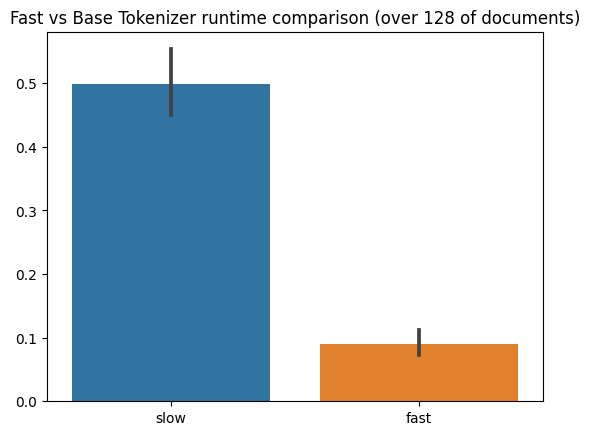

In [21]:
query = {"match_all": {}}
duration_slow = test_scroll(tokenize_slow, query)
duration_fast = test_scroll(tokenize_fast, query)

import seaborn as sns
import matplotlib.pyplot as plt
sns.barplot(x = ["slow"] * len(duration_slow) + ["fast"] * len(duration_fast), y= duration_slow + duration_fast)
plt.title("Fast vs Base Tokenizer runtime comparison (over 128 of documents)")
plt.show()

Total documents found {'value': 211036967, 'relation': 'eq'}
{'_index': 're_pile', '_id': 'train/06.jsonl.gz-5161135', '_score': 1.0, '_source': {'text': '0\t1\n1\t4\n3\t6\n', 'meta': {'pile_set_name': 'Github'}}}
[15, 197, 16, 198, 16, 197, 19, 198, 18, 197, 21, 198]
{'_index': 're_pile', '_id': 'train/01.jsonl.gz-5132111', '_score': 1.0, '_source': {'text': 'package test\n\ntype typeForTest uint32\n', 'meta': {'pile_set_name': 'Github'}}}
[26495, 1332, 198, 198, 4906, 2099, 1890, 14402, 20398, 2624, 198]
{'_index': 're_pile', '_id': 'train/01.jsonl.gz-5155290', '_score': 1.0, '_source': {'text': '<pre>A   XYZ MNO</pre>\n', 'meta': {'pile_set_name': 'Github'}}}
[27, 3866, 29, 32, 220, 220, 41420, 57, 337, 15285, 3556, 3866, 29, 198]
{'_index': 're_pile', '_id': 'train/06.jsonl.gz-5187152', '_score': 1.0, '_source': {'text': 'Why the fuck do you all start school so late\n\n166 shares', 'meta': {'pile_set_name': 'OpenWebText2'}}}
[5195, 262, 5089, 466, 345, 477, 923, 1524, 523, 2739, 19

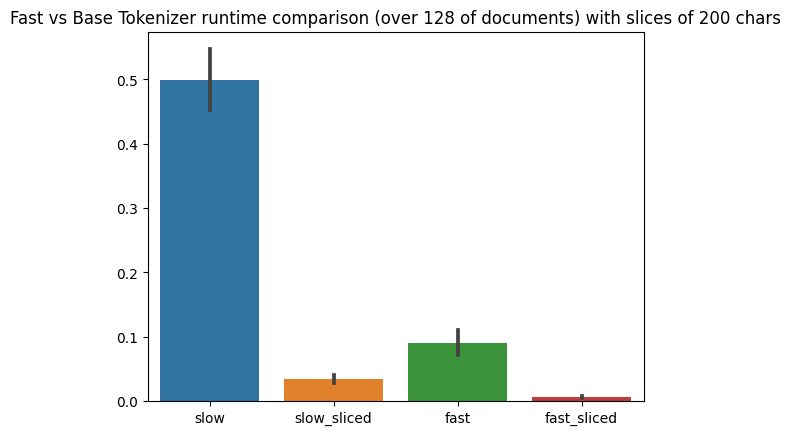

In [57]:
import time as t
import es_utils

def filter_tokens(tokens, tokens_mask):
    """Filter tokens based on the mask"""
    return [token for token, mask in zip(tokens, tokens_mask) if mask]


def test_sliced_scroll(tokenize: callable, query: dict, total_iters=20):
    duration = []
    num_tokens = []
    data = iter(es_utils.scroll(es, query, size=128, scroll="10m", index="re_pile"))

    for i in range(total_iters):
        try:
            docs = next(data)
        except:
            pass
        
        start = t.time()
        results = tokenize([es_utils.get_text(d)[:200] for d in docs])
        duration.append(t.time() - start)
        
        j = 0
        for (inp, mask) in zip(results["input_ids"], results["attention_mask"]):
            tokens = filter_tokens(inp, mask)
            num_tokens.append(len(tokens))
            
            if num_tokens[-1] < 15:
                print(docs[j])
                print(tokens)
                
            j += 1
        
    return duration, num_tokens


query = {"match_all": {}}
duration_sliced_slow, num_tokens_slow = test_sliced_scroll(tokenize_slow, query)
print()
duration_sliced_fast, num_tokens_fast = test_sliced_scroll(tokenize_fast, query)

import seaborn as sns
import matplotlib.pyplot as plt
x = (
    ["slow"] * len(duration_slow) 
    + ["slow_sliced"] * len(duration_sliced_slow)
    + ["fast"] * len(duration_fast)
    + ["fast_sliced"] * len(duration_sliced_fast)
)
y = duration_slow + duration_sliced_slow + duration_fast + duration_sliced_fast
sns.barplot(x=x, y=y)
plt.title("Fast vs Base Tokenizer runtime comparison (over 128 of documents) with slices of 200 chars")
plt.show()

In [51]:
tokenizer_fast.decode([15, 197, 16, 198, 16, 197, 19, 198, 18, 197, 21, 198])


'0\t1\n1\t4\n3\t6\n'

In [58]:
from collections import Counter 

Counter(num_tokens_slow).most_common()

[(15, 2555), (14, 2), (12, 1), (11, 1), (9, 1)]

In [59]:
Counter(num_tokens_fast).most_common()

[(15, 2555), (14, 2), (12, 1), (11, 1), (9, 1)]